In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import scipy as sp

# Harris pixel-wise cornerness detector

(-0.5, 399.5, 399.5, -0.5)

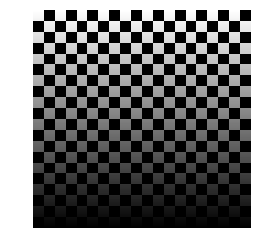

In [2]:
checker = imread('./data/checker.png').astype(float)

plt.imshow(checker, cmap='gray')
plt.axis('off')

In [3]:
sigma_I = 1
sigma_D = 0.7

In [4]:
from scipy.ndimage.filters import gaussian_filter1d

Ix = gaussian_filter1d(checker, sigma=sigma_D, axis=0, order=1, mode='reflect', cval=0.0, truncate=4.0)

## Calculating Gaussian window/weighting function with a standard deviation of $\sigma_I$ = 1

(-0.5, 399.5, 399.5, -0.5)

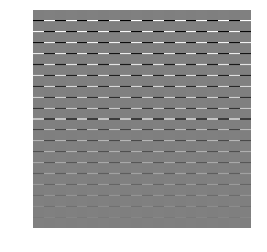

In [5]:
plt.imshow(Ix, cmap='gray')
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

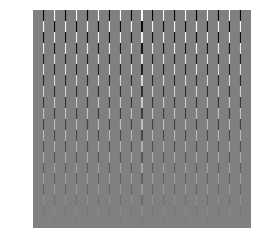

In [6]:
Iy = gaussian_filter1d(checker, sigma=sigma_D, axis=1, order=1, mode='reflect', cval=0.0, truncate=4.0)
plt.imshow(Iy, cmap='gray')
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

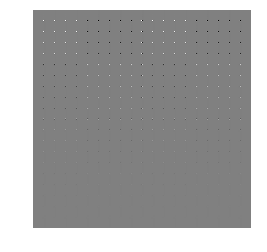

In [7]:
Ix2 = Ix**2
Iy2 = Iy**2
IxIy = Ix*Iy
plt.imshow(IxIy, cmap='gray')
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

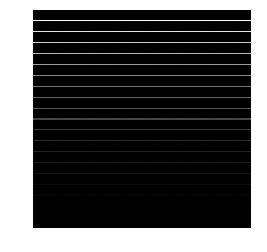

In [8]:
plt.imshow(Ix2, cmap='gray')
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

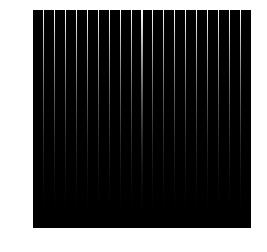

In [9]:
plt.imshow(Iy2, cmap='gray')
plt.axis('off')

## Calculating Gaussian gradients with a standard deviation of $\sigma_D$ = 0.7

In [10]:
from skimage.filters import gaussian

gIx2 = gaussian(Ix2, sigma=sigma_I)
gIy2 = gaussian(Iy2, sigma=sigma_I)
gIxIy = gaussian(IxIy, sigma=sigma_I)

(-0.5, 399.5, 399.5, -0.5)

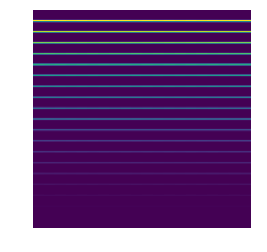

In [11]:
plt.imshow(gIx2)
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

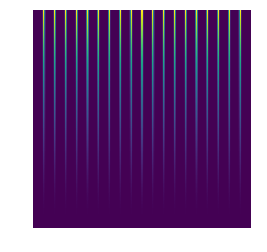

In [12]:
plt.imshow(gIy2)
plt.axis('off')

(-0.5, 399.5, 399.5, -0.5)

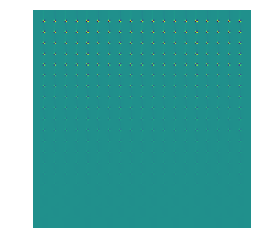

In [13]:
plt.imshow(gIxIy)
plt.axis('off')

In [14]:
R = gIx2*gIy2 - gIxIy**2 + 0.05*(gIx2 + gIy2)**2

(-0.5, 399.5, 399.5, -0.5)

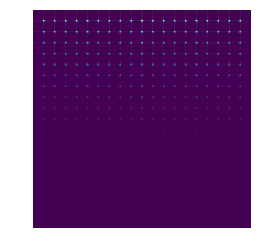

In [15]:
plt.imshow(R)
plt.axis('off')

## Values of R(17:23, 17:23)

In [16]:
print(R[17:23,17:23])

[[  676496.09314496  3780555.4094766   9883847.68484039  9865982.97127339
   3755496.99831505   668724.54802211]
 [ 3754019.83422376 16235231.19731973 36361161.32777982 36264306.7027692
  16113276.88869987  3711651.30752909]
 [ 9778032.80169822 36265426.33939285 76225289.21807778 75954144.12519647
  35953496.39995681  9659446.12921369]
 [ 9745858.33327952 36117968.79049429 75878251.31493734 75608459.32364558
  35807709.09786493  9627836.95430376]
 [ 3708020.40025727 16010829.90067143 35809520.1593225  35715453.83360213
  15892393.0339407   3666784.02479797]
 [  657648.18318335  3664788.83538539  9543228.11556564  9528069.18782379
   3643154.53098024   650857.79718807]]


## Threshold R

In [17]:
R_fix = R - 1000000
R_fix[R_fix < 0] = 0

(-0.5, 399.5, 399.5, -0.5)

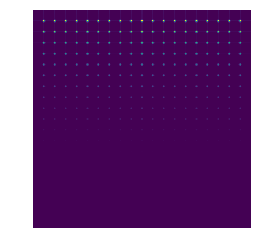

In [18]:
plt.imshow(R_fix)
plt.axis('off')

```
def nonmaxSuppress(inp):
    m = np.max(inp)
    l = len(inp)
    ct = 0
    for el in inp:
        if el == m:
            ct+=1
    if ct ==1:
        return inp[l//2]
    else:
        return 0
```

```
from scipy.ndimage.filters import generic_filter

R_sup = generic_filter(R, nonmaxSuppress, size=(3,3))
```

Ignore the above, it was a prototype convolution operation of what I thought non-maximal suppression was supposed to be

In [19]:
def checkIfUniqueMax(image, row, col):
    cVal = image[row][col]
    
    m = np.max(image[row-1:row+2,col-1:col+2])
    c = 0
    
    for i in range(row-1, row+2):
        for j in range(col-1, col+2):
            if image[i][j] == m:
                c += 1
    
    return image[row][col]==m and c==1

## Non-maximal Suppression

In [20]:
def nonmaxSuppress(image):
    corners = []
    rows,cols = image.shape
    startSearchRow = 1
    endSearchRow = rows-1 # search the middle square of the frame
    startSearchCol = 1
    endSearchCol = cols-1

    # Begin searching through search area
    for row in range(startSearchRow, endSearchRow):
        for col in range(startSearchCol, endSearchCol):
            if checkIfUniqueMax(image, row, col):
                corners.append((col, row))
    return corners;

In [21]:
c = nonmaxSuppress(R_fix)

(-0.5, 399.5, 399.5, -0.5)

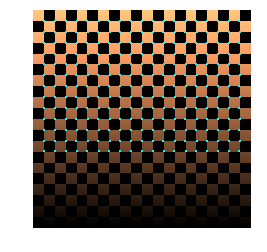

In [22]:
x_list = [x for x, y in c]
y_list = [y for x, y in c]

plt.scatter(x_list,y_list, s=5, marker='+', color='aqua')
plt.imshow(checker, cmap='copper')
plt.axis('off')

We notice that the non maximal suppression has actually revealed some of the "hidden" corners that our $R$ missed earlier. This is interesting because as we would see below, this leads to a result comparable to the more computationally expensive corner detector, the Shi-Tomasi detector. Thus I hypothesize that the non-maximal suppression is actually playing around with the eigenvalue regions that we saw in the slides, making the decision boundary look more like Shi-Tomasi's boxed layout rather than the conical layout of a true Harris' corner detector.

# FAST feature point detector

Reference:
![im](https://docs.opencv.org/3.0-beta/_images/fast_speedtest.jpg)

In [23]:
def circle(row, col):
    point1 = (row+3, col)
    
    point2 = (row+3, col+1)
    
    point3 = (row+2, col+2)
    
    point4 = (row+1, col+3)
    
    point5 = (row, col+3)
    
    point6 = (row-1, col+3)
    
    point7 = (row-2, col+2)
    
    point8 = (row-3, col+1)
    
    point9 = (row-3, col)
    
    point10 = (row-3, col-1)
    
    point11 = (row-2, col-2)
    
    point12 = (row-1, col-3)
    
    point13 = (row, col-3)
    
    point14 = (row+1, col-3)
    
    point15 = (row+2, col-2)
    
    point16 = (row+3, col)
    
    return [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11, point12, point13, point14, point15]

In [24]:
def is_corner(image, row, col, ROI, threshold, n_star):
    intensity = int(image[row][col])
    circ = []
    for el in ROI:
        if image[el[0]][el[1]] > intensity+threshold:
            circ.append(1)
        elif image[el[0]][el[1]] < intensity-threshold:
            circ.append(2)
        else:
            circ.append(0)
    for el in ROI:
        if image[el[0]][el[1]] > intensity+threshold:
            circ.append(1)
        elif image[el[0]][el[1]] < intensity-threshold:
            circ.append(2)
        else:
            circ.append(0)
    i =0
    el = circ[i]
    count = 1
    largest_ct = count
    for i in range(1, len(circ)):
        if circ[i] == el and circ[i] != 0:
            count += 1
        else:
            if circ[i] == 0:
                el = 0
            if circ[i] != 0:
                if largest_ct < count:
                    largest_ct = count
                count = 1
                el = circ[i]

    return largest_ct >= n_star

In [25]:
def detect(image, threshold=50):
    # Initialization
    corners = []
    rows,cols = image.shape
    startSearchRow = 3
    endSearchRow = rows-3
    startSearchCol = 3
    endSearchCol = cols-3
    n_star = 9

    # Begin searching through search area
    for row in range(startSearchRow, endSearchRow):
        for col in range(startSearchCol, endSearchCol):
            ROI = circle(row, col) 
            if is_corner(image, row, col, ROI, threshold, n_star):
                corners.append((col, row))
    return corners;

In [26]:
tower = imread('./data/tower.png')

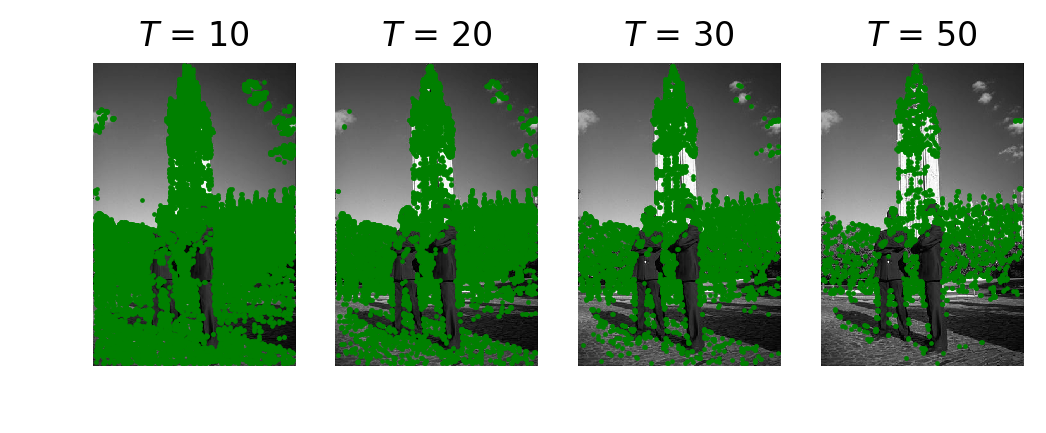

In [27]:
thresholds = [10, 20, 30, 50]

plt.close('all')
f, axarr = plt.subplots(1, 4, dpi=200)
for thresh in thresholds:
    c = detect(tower, thresh)
    idx = thresholds.index(thresh)
    x_list = [x for x, y in c]
    y_list = [y for x, y in c]
    axarr[idx%4].axis('off')
    axarr[idx%4].scatter(x_list,y_list, s=0.5, color='green')
    axarr[idx%4].set_title(f'$T$ = {thresh}')
    axarr[idx%4].imshow(tower, cmap='gray')

We notice that our FAST detector performs similar to the ones on slides, and also similar to the standard library implementation (given below). This is suprising because the standard library version uses a fast approximation where it only checks a select "points" that were pre-determined to be useful instead of checking if the entire array passes the $n^*$ test like we do. (This version also is noticeably faster because of less looping and branching required along with lesser memory overhead as the amount of points required in this method is nearly half.

# Bonus comparision with standard library results

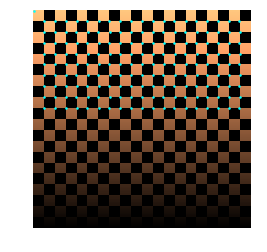

In [28]:
from skimage.feature import corner_harris, corner_fast, corner_subpix, corner_peaks, corner_shi_tomasi
coords = corner_peaks(corner_harris(checker), min_distance=1)
coords_subpix = corner_subpix(checker, coords, window_size=1)
fig, ax = plt.subplots()
ax.imshow(checker, interpolation='nearest', cmap='copper')
ax.axis('off')
ax.plot(coords[:, 1], coords[:, 0], '.b', c='aqua', markersize=3)
plt.show()

We notice that they get results that we got earlier (with R), but since they haven't applied our variation of non-maximal suppression they loose some of the lower corners.

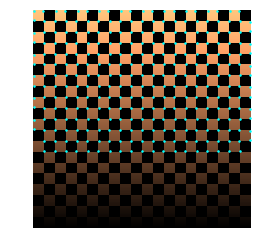

In [29]:
coords = corner_peaks(corner_shi_tomasi(checker), min_distance=1)
coords_subpix = corner_subpix(checker, coords, window_size=1)
fig, ax = plt.subplots()
ax.imshow(checker, interpolation='nearest', cmap='copper')
ax.axis('off')
ax.plot(coords[:, 1], coords[:, 0], '.b', c='aqua', markersize=3)
plt.show()

The Shi-Tomasi corner detector gives us results comparable to our implementation of Harris.

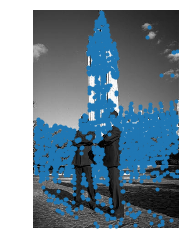

In [30]:
coords = corner_peaks(corner_fast(tower, 10), min_distance=1)
coords_subpix = corner_subpix(tower, coords, window_size=3)
fig, ax = plt.subplots()
ax.imshow(tower, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.')
ax.axis('off')
plt.show()

Fairly similar results at similar threshold as our implementation, but at a fraction of the computational overhead. Argument could be made about it tripping up on some more complex image.